# Case study: Acheron rock avalanche

In [1]:
import os
# Fix for OpenMP library conflicts on macOS
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import numpy as np
import time
import torch
import matplotlib.pyplot as plt
from pathlib import Path
import subprocess
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from psimpy.sampler.latin import LHS
from psimpy.emulator import PPGaSP, PCAPPGaSP
from psimpy.emulator import OutputDimReducer, LinearPCA, NonlinearPCA
from psimpy.utility import reduced_dim
from gpytorch_emulator import MoGP_GPytorch, PCA_MoGP_GPytorch, MultiTask_GP
from autoencoder import AutoEncoder, VAE
from utils.error_metrics import ErrorMetrics
from utils.plot import viz_prediction, viz_residuals, viz_output_image, viz_diff_grid_points, plot_pca_zero_output_hist
from utils.preprocess import zero_truncated_data

## Data setup

In [2]:
# Get the root directory of the repository
def get_repo_root() -> Path:
    root = subprocess.check_output(["git", "rev-parse", "--show-toplevel"])
    return Path(root.decode().strip())

DATA_PATH = get_repo_root() / "data"
QOI = "hmax"
THRESHOLD = 0.5

In [3]:
def load_dataset(input_filepath, output_filepath, valid_columns=None, threshold: float = 0.5):
    input_data = np.genfromtxt(input_filepath, delimiter=',', skip_header=1)    
    output_data, valid_cols, rows, cols = zero_truncated_data(output_filepath, threshold=threshold,  valid_cols=valid_columns) 
    return input_data, output_data, valid_cols, rows, cols

In [4]:
train_data_root_folder = os.path.join(DATA_PATH, "acheron", "train")
test_data_root_folder = os.path.join(DATA_PATH, "acheron", "test")
train_input_filepath = os.path.join(train_data_root_folder, "input", "acheron_emulator.csv")
train_output_filepath = os.path.join(train_data_root_folder, "output", QOI + "_stack.tif") 
test_input_filepath = os.path.join(test_data_root_folder, "input", "acheron_validation_emulator.csv")
test_output_filepath = os.path.join(test_data_root_folder, "output", QOI + "_stack.tif") 
hill_path = None
train_X, train_Y, valid_cols, rows, cols = load_dataset(train_input_filepath, train_output_filepath, threshold=THRESHOLD)
test_X, test_Y, _, _, _ = load_dataset(test_input_filepath, test_output_filepath, threshold=THRESHOLD, valid_columns=valid_cols)
print(f"Train X shape: {train_X.shape}, Train Y shape: {train_Y.shape}")
print(f"Test X shape: {test_X.shape}, Test Y shape: {test_Y.shape}")

Train X shape: (100, 3), Train Y shape: (100, 12195)
Test X shape: (20, 3), Test Y shape: (20, 12195)


## GP variants
### (1) PPGaSP in RobustGaSP

In [ ]:
# Model setup
emulator = PPGaSP(ndim=train_X.shape[1])
    
# Training
start_time = time.time()
emulator.train(design=train_X, response=train_Y)
training_time = time.time() - start_time

# Prediction
start_time = time.time()
predictions = emulator.predict(test_X)
infer_time = time.time() - start_time

predictions_mean = predictions[:, :, 0]
predictions_lower = predictions[:, :, 1]
predictions_upper = predictions[:, :, 2]
predictions_std = predictions[:, :, 3]

ppgasp_results = {
    "prediction_mean": predictions_mean,
    "prediction_std": predictions_std,
    "training_time": training_time,
    "infer_time": infer_time
}

### (2) BiGP (PPGaSP in GPytorch)

In [5]:
# Model setup
device = "cuda" if torch.cuda.is_available() else "cpu"
emulator = MoGP_GPytorch(device=device, kernel_type='matern_5_2')

# Training
training_time = emulator.train(train_X=train_X, train_Y=train_Y, num_epochs=50, lr=0.1, optim="adamw")

# Prediction
mean, std, lower, upper, infer_time = emulator.predict(test_X=test_X)

bigp_results = {
    "prediction_mean": mean,
    "prediction_std": std,
    "training_time": training_time,
    "infer_time": infer_time
}

training...:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0/50, Loss: 1.757


training...:  20%|██        | 10/50 [01:48<06:26,  9.67s/it]

Epoch 10/50, Loss: 1.496


training...:  40%|████      | 20/50 [03:12<03:35,  7.18s/it]

Epoch 20/50, Loss: 1.219


training...:  60%|██████    | 30/50 [04:20<02:28,  7.44s/it]

Epoch 30/50, Loss: 0.996


training...:  80%|████████  | 40/50 [06:06<01:54, 11.45s/it]

Epoch 40/50, Loss: 0.928


training...: 100%|██████████| 50/50 [09:10<00:00, 11.02s/it]


Training GPytorch takes 550.901 s


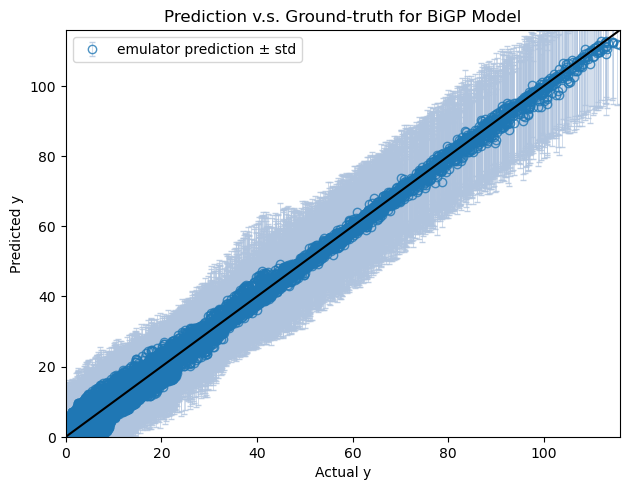

In [6]:
preds = np.dstack((mean, std))
viz_prediction(test_Y, preds, model_name="BiGP")